In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
# Load LP results

lp_genActPower = pd.read_csv('results/cplex_pyomo/genActPower.csv')
lp_genExcActPower = pd.read_csv('results/cplex_pyomo/genExcActPower.csv')

lp_pImp = pd.read_csv('results/cplex_pyomo/pimp.csv')
lp_pExp = pd.read_csv('results/cplex_pyomo/pexp.csv')

lp_storEner = pd.read_csv('results/cplex_pyomo/storEnerState.csv')
lp_v2gEner = pd.read_csv('results/cplex_pyomo/v2gEnerState.csv')

In [4]:
# Load Metaheuristic results

hydedf_solutions = pd.read_csv('results/hyde_df/solutions.csv')
hydedf_history = pd.read_csv('results/hyde_df/history.csv')
hydedf_fit = pd.read_csv('results/hyde_df/fit+time.csv')

In [5]:
# Decode solution vector aux

def encode(var_dictionary):
    result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
    return result_concat


def decode(var_vector, var_dictionary):
    result_decoded = {}
    var_idx = [var_dictionary[v].ravel().shape[0] for v in var_dictionary.keys()]

    current_index = 0
    dictionary_names = list(var_dictionary.keys())
    
    for idx in np.arange(len(dictionary_names)):
        result_index = current_index + var_idx[idx]
        result_decoded[dictionary_names[idx]] = np.reshape(var_vector[current_index:result_index], 
                                                           var_dictionary[dictionary_names[idx]].shape)
        
        current_index = result_index
        
    return result_decoded

In [8]:
# Build dictionary for decoding

_gen = 7
_t = 24
_Load = 6
_stor = 3
_v2g = 5
_cs = 3

# Positive variables

# Generation variables
genActPower = np.ones(shape=(_gen, _t))
genExcActPower = np.ones(shape=(_gen, _t))
pImp = np.ones(shape=(_t))
pExp = np.ones(shape=(_t))

# Load variables
loadRedActPower = np.ones(shape=(_Load, _t))
loadCutActPower = np.ones(shape=(_Load, _t))
loadENS = np.ones(shape=(_Load, _t))

# Storage variables
storDchActPower = np.ones(shape=(_stor, _t))
storChActPower = np.ones(shape=(_stor, _t))
storEminRelaxStor = np.ones(shape=(_stor, _t))
storEnerState = np.ones(shape=(_stor, _t))

# V2G variables
v2gDchActPower = np.ones(shape=(_v2g, _t))
v2gChActPower = np.ones(shape=(_v2g, _t))
v2gEnerState = np.ones(shape=(_v2g, _t))
v2gEminRelaxEv = np.ones(shape=(_v2g, _t))

# Charging Stations
csActPower = np.ones(shape=(_cs, _t))
csActPowerNet = np.ones(shape=(_cs, _t))

# Binary variables
genXo = np.zeros(shape=(_gen, _t))
loadXo = np.zeros(shape=(_Load, _t))

storChXo = np.zeros(shape=(_stor, _t))
storDchXo = np.zeros(shape=(_stor, _t))

v2gChXo = np.zeros(shape=(_v2g, _t))
v2gDchXo = np.zeros(shape=(_v2g, _t))


dict_var = {'genActPower': genActPower,
            'genExcActPower': genExcActPower,
            'pImp': pImp,
            'pExp': pExp,
            'loadRedActPower': loadRedActPower,
            'loadCutActPower': loadCutActPower,
            'loadENS': loadENS,
            'storDchActPower': storDchActPower,
            'storChActPower': storChActPower,
            'storEnerState': storEnerState,
            'v2gDchActPower': v2gDchActPower,
            'v2gChActPower': v2gChActPower,
            'v2gEnerState': v2gEnerState,
            'csActPower': csActPower,
            'csActPowerNet': csActPowerNet,
            'genXo': genXo,
            'loadXo': loadXo,
            'storDchXo': storDchXo,
            'storChXo': storChXo,
            'v2gDchXo': v2gDchXo,
            'v2gChXo': v2gChXo}

In [106]:
# Decode the best solution

hydedf_decoded = decode(hydedf_solutions['run{:02d}'.format(np.argmin(hydedf_fit['Fit'])+1)].values, dict_var)

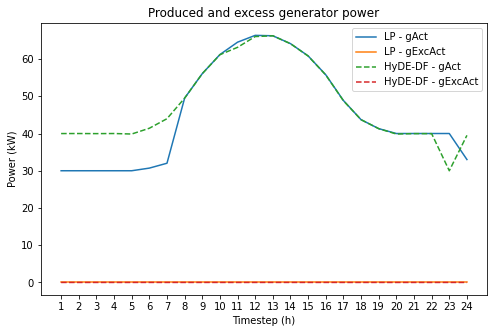

In [107]:
# Plot the total amount of generated power and exc. power

fig = plt.figure(figsize=(8, 5))

# Plot 
plt.plot(np.sum(lp_genActPower, axis=0), label='LP - gAct')
plt.plot(np.sum(lp_genExcActPower, axis=0), label='LP - gExcAct')

plt.plot(np.sum(hydedf_decoded['genActPower'], axis=0), '--', label='HyDE-DF - gAct')
plt.plot(np.sum(hydedf_decoded['genExcActPower'], axis=0), '--', label='HyDE-DF - gExcAct')

plt.legend()
plt.title('Produced and excess generator power')

plt.ylabel('Power (kW)')
plt.xlabel('Timestep (h)')

plt.show()

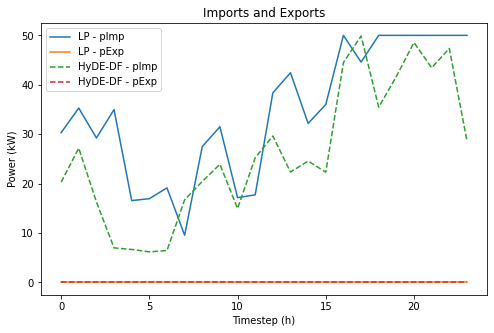

In [108]:
# Plot the imports and export

fig = plt.figure(figsize=(8, 5))

# Plot 
plt.plot(lp_pImp, label='LP - pImp')
plt.plot(lp_pExp, label='LP - pExp')

plt.plot(hydedf_decoded['pImp'], '--', label='HyDE-DF - pImp')
plt.plot(hydedf_decoded['pExp'], '--', label='HyDE-DF - pExp')

plt.legend()
plt.title('Imports and Exports')

plt.ylabel('Power (kW)')
plt.xlabel('Timestep (h)')

plt.show()

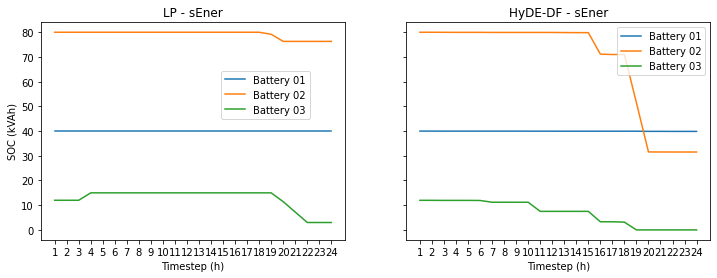

In [109]:
# Plot the storage

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 4), sharex=True, sharey=True)

# Plot LP
for s in range(lp_storEner.shape[0]):
    axs[0].plot(lp_storEner.iloc[s], label='Battery {:02d}'.format(s+1))
    
axs[0].set_title('LP - sEner')
axs[0].legend(loc='upper right', bbox_to_anchor=(0.9, 0.8))

axs[0].set_ylabel('SOC (kVAh)')
axs[0].set_xlabel('Timestep (h)')
    
for s in range(hydedf_decoded['storEnerState'].shape[0]):
    axs[1].plot(hydedf_decoded['storEnerState'][s], label='Battery {:02d}'.format(s+1))
    
axs[1].set_title('HyDE-DF - sEner')
axs[1].legend()

axs[1].set_xlabel('Timestep (h)')

plt.show()

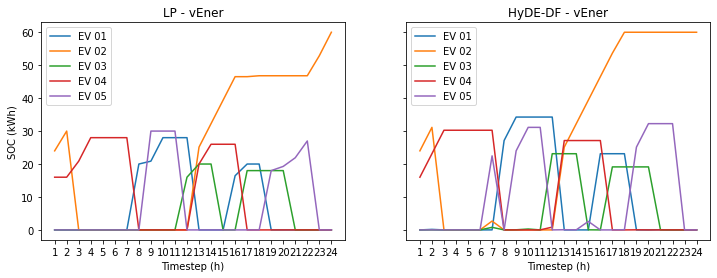

In [110]:
# Plot the vehicles

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 4), sharex=True, sharey=True)

# Plot LP
for v in range(lp_v2gEner.shape[0]):
    axs[0].plot(lp_v2gEner.iloc[v], label='EV {:02d}'.format(v+1))
    
axs[0].set_title('LP - vEner')
axs[0].legend()

axs[0].set_ylabel('SOC (kWh)')
axs[0].set_xlabel('Timestep (h)')
    
for v in range(hydedf_decoded['v2gEnerState'].shape[0]):
    axs[1].plot(hydedf_decoded['v2gEnerState'][v], label='EV {:02d}'.format(v+1))
    
axs[1].set_title('HyDE-DF - vEner')
axs[1].legend()
axs[1].set_xlabel('Timestep (h)')

plt.show()

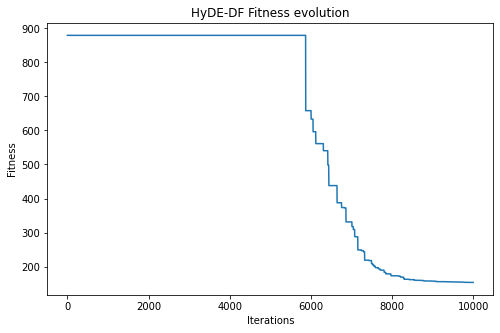

In [114]:
# Plot HyDE-DF fitness history

fig = plt.figure(figsize=(8, 5))

plt.plot(hydedf_history['run{:02d}'.format(np.argmin(hydedf_fit['Fit'])+1)])

plt.ylabel('Fitness')
plt.xlabel('Iterations')

plt.title('HyDE-DF Fitness evolution')

plt.show()